## Full Spectrum (widest) Combined
### from New Data/Spectrum blocked (widest)/A0036 and New Data/Spectrum (widest)/A0035

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [2]:
# Calibration numbers come from multiple calibrations with proper error analysis and weighted averaging
# Calulations can be found in "Multiple Plot Calibration"
CalM = -5.169066740202884
#CalM_err = 1.8472146461547026e-06
CalM_err = 0.36697628437204854

# define functions
def LinearFunc(t, a, b):
    return a * t + b

def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))

def Cali(t, t0, DriveSlope):
    return (10 * DriveSlope * CalM * (t - t0))

def Cali_Err(t, t_err, t0, t0_err, DriveSlope, DriveSlope_err):
    return np.sqrt( (10 * DriveSlope_err * CalM * (t - t0))**2 +
                    (10 * DriveSlope * CalM_err * (t - t0))**2 +
                    (10 * DriveSlope * CalM * t_err)**2 +
                    (10 * DriveSlope * CalM * t0_err)**2 )

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, (len(params)-2), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( (-1/2) * ((x - ctr)/wid)**2)
    return y + x * params[12] + params[13]

36.296814456069576
0.023327224386140384


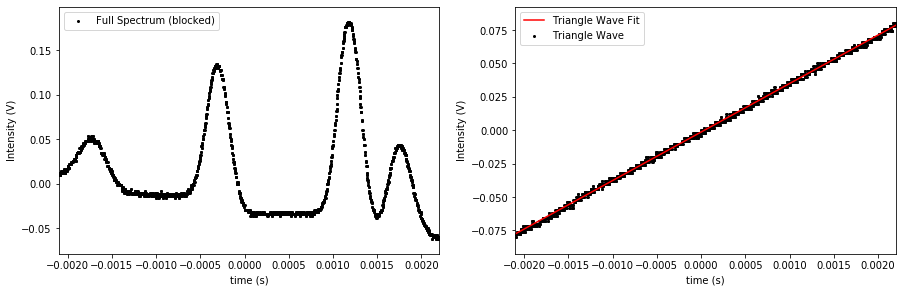

In [3]:
data =  pd.read_csv("New Data/Spectrum blocked (widest)/A0036CH1.CSV")
x = pd.DataFrame(data, columns= ['col 1'])
y = pd.DataFrame(data, columns= ['col 2'])
x = np.resize(x,(4000,1))
y = np.resize(y,(4000,1))

rampdata =  pd.read_csv("New Data/Spectrum blocked (widest)/A0036CH2.CSV")
rampx = pd.DataFrame(rampdata, columns= ['col 1'])
rampy = pd.DataFrame(rampdata, columns= ['col 2'])
rampx = np.resize(rampx,(4000,1))
rampy = np.resize(rampy,(4000,1))

#plt.plot(rampx,rampy)

t_start = -0.0021
t_end = 0.0022

j = 0
for i in x:
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    j += 1

x = x[t1:t2,0]
y = y[t1:t2,0]
rampx = rampx[t1:t2,0]
rampy = rampy[t1:t2,0]

RampGuess = [36, 0.2]
RampParam, RampParam_cov = curve_fit(LinearFunc, rampx, rampy, RampGuess, maxfev=150000)

RampSlope = RampParam[0]
RampSlope_err = RampParam_cov[0,0]
print(RampSlope)
print(np.sqrt(RampParam_cov[0,0]))

fig = plt.figure(figsize=(15,10))

fig1 = fig.add_subplot(2,2,1)
fig1.scatter(x, y, label='Full Spectrum (blocked)', color='black', s=4)
fig1.set_xlim(t_start,t_end)
fig1.set_xlabel("time (s)")
fig1.set_ylabel("Intensity (V)")
fig1.legend();

fig2 = fig.add_subplot(2,2,2)
fig2.scatter(rampx, rampy, label='Triangle Wave', color='black', s=4)
fig2.plot(rampx, LinearFunc(rampx,*RampParam), label='Triangle Wave Fit', color='red')
fig2.set_xlim(t_start,t_end)
fig2.set_xlabel("time (s)")
fig2.set_ylabel("Intensity (V)")
fig2.legend();

Y-error = (+/-) 0.0015998967505494457
[-2.62716022 -0.01513832]


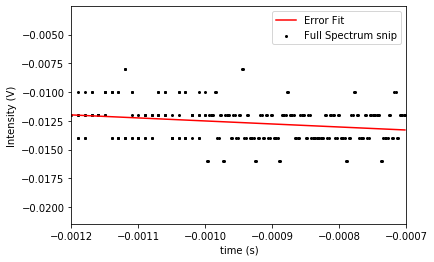

In [4]:
# Finds Error in the voltage

# Find flat '0' segments
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == -0.0012:
        t1 = j
    if i == -0.0007:
        t2 = j
    j += 1
    
x_back = x[t1:t2]
y_back = y[t1:t2]

Back_guess = [-18,-.014]

Back_popt, Back_pcov = optimize.curve_fit(LinearFunc, x_back, y_back, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_back - LinearFunc(x_back, *Back_popt))**2 ) / (np.size(x_back) - 2) )

print("Y-error = (+/-) " + str(V_error))

print(Back_popt)

V_errorA = V_error * np.linspace(1,1,np.size(x))
    
fig = plt.figure()
fig1 = fig.add_subplot(1,1,1)
fig1.scatter(x_back, y_back, label='Full Spectrum snip', color='black', s=4)
fig1.plot(x_back, LinearFunc(x_back, *Back_popt), label='Error Fit', color='red')
fig1.set_xlim(-0.0012,-0.0007)
fig1.set_xlabel("time (s)")
fig1.set_ylabel("Intensity (V)")
fig1.legend();

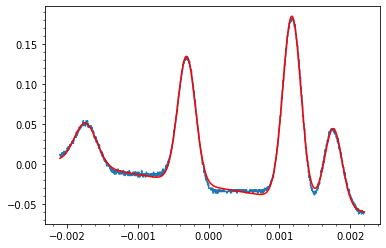

Reduced Chi Squared = 3.764202263548545


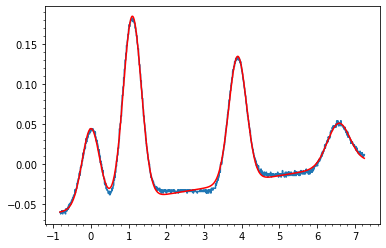

[-0.          1.09905929  3.89143743  6.56971504]
[0.00142563 0.07803509 0.27627394 0.46642071]

[-1.42562551e-03  1.02102420e+00  3.61516349e+00  6.10329433e+00]
[1.42562551e-03 1.17709438e+00 4.16771137e+00 7.03613575e+00]


[0.54510292 0.56384356 0.55415317 0.70461975]
[0.03880445 0.04004605 0.03937321 0.05040382]

[0.50629846 0.52379751 0.51477995 0.65421593]
[0.58390737 0.60388961 0.59352638 0.75502357]


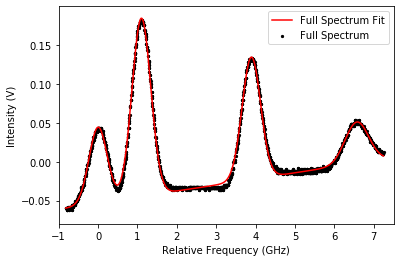

In [5]:
# Fit curve, apply Calibration
guess = [-0.0018, 0.05000, 0.00020, -0.0003, 0.15000, 0.00020, 0.001, 0.21000, 0.00020, 0.0015, 0.05000, 0.00020, -18, -.0138]
# position, amplitude, width

popt, pcov = optimize.curve_fit(func, x, y, p0=guess, sigma= V_errorA, maxfev=200000)
fit = func(x, *popt)

#Rb87F1, Rb85F2, Rb85F3, Rb87F2
PosArray = np.array([popt[9], popt[6], popt[3], popt[0]])
PosErrArray = np.array([np.sqrt(pcov[9,9]), np.sqrt(pcov[6,6]), np.sqrt(pcov[3,3]), np.sqrt(pcov[0,0])])
WidthArray = np.array([popt[11], popt[8], popt[5], popt[2]])
WidthErrArray = np.array([np.sqrt(pcov[11,11]), np.sqrt(pcov[8,8]), np.sqrt(pcov[5,5]), np.sqrt(pcov[2,2])])

FWHMArray = 2.35482 * WidthArray
FWHMErrArray = 2.35482 * WidthErrArray

RCS = RdChiSqrd(y, func(x, *popt), V_error, 12)

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()
print("Reduced Chi Squared = " + str(RCS))

#print(PosArray)

ZeroPos = popt[9]
ZeroPos_err = np.sqrt(pcov[9,9])

#Cali(t, t0, DriveSlope)
#Cali_Err(t, t_err, t0, t0_err, DriveSlope, DriveSlope_err)

# Calibration on all points
Calx = Cali(x, PosArray[0], RampSlope)

plt.plot(Calx, y)
plt.plot(Calx, func(x, *popt), 'r-')
plt.minorticks_on()
plt.show()

fig = plt.figure()
fig1 = fig.add_subplot(1,1,1)
fig1.scatter(Calx, y, label='Full Spectrum', color='black', s=5)
fig1.plot(Calx, func(x, *popt), label='Full Spectrum Fit', color='red')
fig1.set_xlim(-1,7.5)
fig1.set_xlabel("Relative Frequency (GHz)")
fig1.set_ylabel("Intensity (V)")
fig1.legend();

CalPosArray = Cali(PosArray, PosArray[0], RampSlope)
CalPosErrArray = Cali_Err(PosArray, PosErrArray, PosArray[0], PosErrArray[0], RampSlope, RampSlope_err)

CalWidthArray = (-1)*Cali(WidthArray, 0, RampSlope)



CalWidthErrArray1 = Cali_Err(WidthArray, WidthErrArray, 0, 0, RampSlope, RampSlope_err)
#CalWidthErrArray2 = Cali_Err(WidthArray, WidthErrArray, PosArray, PosErrArray, RampSlope, RampSlope_err)
#CalWidthErrArray3 = Cali_Err(WidthArray, WidthErrArray, PosArray[0], PosErrArray[0], RampSlope, RampSlope_err)

CalFWHMArray = 2.35482 * CalWidthArray
CalFWHMErrArray = 2.35482 * CalWidthErrArray1

print(CalPosArray)
print(CalPosErrArray)
print("")
print(CalPosArray-CalPosErrArray)
print(CalPosArray+CalPosErrArray)
print("")
print("")
print(CalFWHMArray)
print(CalFWHMErrArray)
print("")
print(CalFWHMArray-CalFWHMErrArray)
print(CalFWHMArray+CalFWHMErrArray)

## Unblocked

36.17791535741955
0.022050483639657142


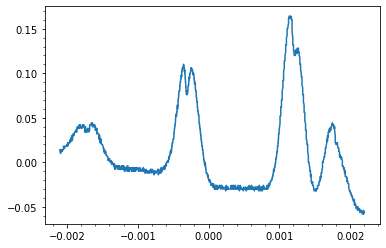

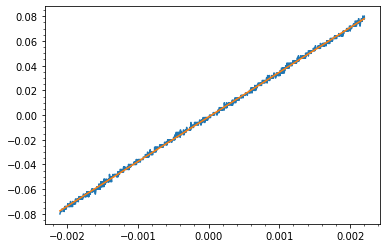

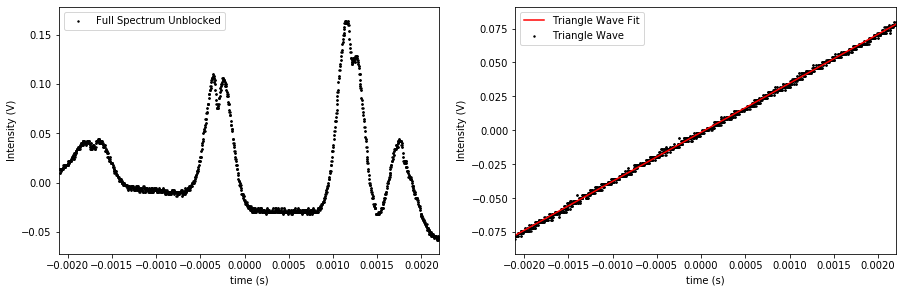

In [6]:
Udata =  pd.read_csv("New Data/Spectrum (widest)/A0035CH1.CSV")
Ux = pd.DataFrame(Udata, columns= ['col 1'])
Uy = pd.DataFrame(Udata, columns= ['col 2'])
Ux = np.resize(Ux,(4000,1))
Uy = np.resize(Uy,(4000,1))

Urampdata =  pd.read_csv("New Data/Spectrum (widest)/A0035CH2.CSV")
Urampx = pd.DataFrame(Urampdata, columns= ['col 1'])
Urampy = pd.DataFrame(Urampdata, columns= ['col 2'])
Urampx = np.resize(Urampx,(4000,1))
Urampy = np.resize(Urampy,(4000,1))

#plt.plot(Urampx,Urampy)

t_start = -0.0021
t_end = 0.0022

j = 0
for i in Ux:
    if i == t_start:
        Ut1 = j
    if i == t_end:
        Ut2 = j
    j += 1

Ux = Ux[Ut1:Ut2,0]
Uy = Uy[Ut1:Ut2,0]
Urampx = Urampx[Ut1:Ut2,0]
Urampy = Urampy[Ut1:Ut2,0]

URampGuess = [36, 0.2]
URampParam, URampParam_cov = curve_fit(LinearFunc, Urampx, Urampy, URampGuess, maxfev=150000)

URampSlope = URampParam[0]
print(URampSlope)
print(np.sqrt(URampParam_cov[0,0]))

plt.plot(Ux,Uy)
plt.minorticks_on()
plt.show()
plt.plot(Urampx,Urampy)
plt.plot(Urampx,LinearFunc(Urampx,*URampParam))
plt.minorticks_on()
plt.show()

fig = plt.figure(figsize=(15,10))

fig1 = fig.add_subplot(2,2,1)
fig1.scatter(Ux, Uy, label='Full Spectrum Unblocked', color='black', s=2)
fig1.set_xlim(t_start,t_end)
fig1.set_xlabel("time (s)")
fig1.set_ylabel("Intensity (V)")
fig1.legend();

fig2 = fig.add_subplot(2,2,2)
fig2.scatter(Urampx, Urampy, label='Triangle Wave', color='black', s=2)
fig2.plot(Urampx, LinearFunc(Urampx,*URampParam), label='Triangle Wave Fit', color='red')
fig2.set_xlim(t_start,t_end)
fig2.set_xlabel("time (s)")
fig2.set_ylabel("Intensity (V)")
fig2.legend();

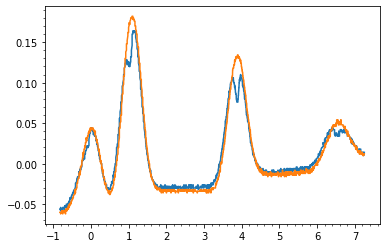

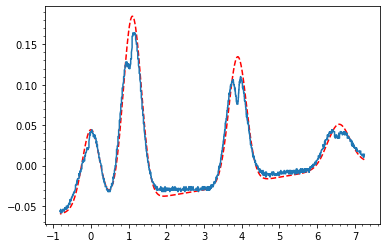

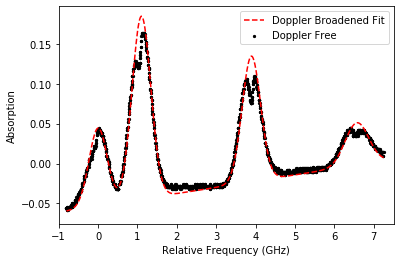

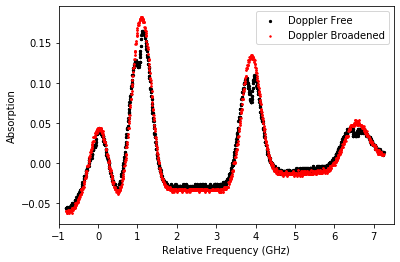

In [19]:
UCalx = Cali(Ux, ZeroPos, RampSlope)
UyFlat = Uy - LinearFunc(UCalx, popt[12], popt[13])

plt.plot(UCalx, Uy)
plt.plot(Calx, y)
plt.minorticks_on()
plt.show()

plt.plot(UCalx, func(Ux, *popt), 'r--')
plt.plot(UCalx, Uy)
plt.minorticks_on()
plt.show()

fig = plt.figure()
fig1 = fig.add_subplot(1,1,1)
fig1.scatter(UCalx, Uy, label='Doppler Free', color='black', s=5)
fig1.plot(UCalx, func(Ux, *popt), 'r--', label='Doppler Broadened Fit')
fig1.set_xlim(-1,7.5)
fig1.set_xlabel("Relative Frequency (GHz)")
fig1.set_ylabel("Absorption")
fig1.legend();
fig.savefig('DopplerShiftWithFit.jpg', bbox_inches='tight', dpi=150)

fig = plt.figure()
fig1 = fig.add_subplot(1,1,1)
fig1.scatter(UCalx, Uy, label='Doppler Free', color='black', s=5)
fig1.scatter(UCalx, y, label='Doppler Broadened', color='red', s=2)
fig1.set_xlim(-1,7.5)
fig1.set_xlabel("Relative Frequency (GHz)")
fig1.set_ylabel("Absorption")
fig1.legend();
fig.savefig('DopplerShiftWithMeausre.jpg', bbox_inches='tight', dpi=150)

#plt.plot(Calx, yFlat)
#plt.plot(UCalx, UyFlat)
#plt.minorticks_on()
#plt.show()

In [8]:
CalPosArray1 = CalPosArray
CalPosErrArray1 = CalPosErrArray

CalPosArray2 = [0., 1.09858207, 3.88023459, 6.39650636]
CalPosErrArray2 = [0.00134133, 0.07800033, 0.27547829, 0.45412247]

CalPosArray_Avg = [1, 1, 1, 1]
CalPosErrArray_Avg = [1, 1, 1, 1]
i = 0
while i < 4:
    CalPosArray_Avg[i] = ((CalPosArray1[i]/CalPosErrArray1[i]**2) + (CalPosArray2[i]/CalPosErrArray2[i]**2)) / ((1/CalPosErrArray1[i]**2) + (1/CalPosErrArray2[i]**2))
    CalPosErrArray_Avg[i] = np.sqrt(1/ ((1/CalPosErrArray1[i]**2) + (1/CalPosErrArray2[i]**2)))
    i += 1


#Muliplier_Avg = ((Muliplier1/Muliplier1_Var) + (Muliplier2/Muliplier2_Var)) / ((1/Muliplier1_Var) + (1/Muliplier2_Var))
#Muliplier_Avg_Err = 1/( (1/Muliplier1_Var) + (1/Muliplier2_Var) )

print(CalPosArray_Avg)
print(CalPosErrArray_Avg)


[0.0, 1.098820573707976, 3.8858198537874755, 6.480797083506978]
[0.0009769053131712237, 0.0551668475848026, 0.19507326360275415, 0.32537403758308064]


In [9]:
CalFWHMArray1 = CalFWHMArray
CalFWHMErrArray1 = CalFWHMErrArray

CalFWHMArray2 = [0.56634773,  0.57280065, 0.55730562,  0.62641355]
CalFWHMErrArray2 = [0.04028145, 0.04067869, 0.03959105, 0.04469084]

CalFWHMArray_Avg = [1, 1, 1, 1]
CalFWHMErrArray_Avg = [1, 1, 1, 1]
i = 0
while i < 4:
    CalFWHMArray_Avg[i] = ((CalFWHMArray1[i]/CalFWHMErrArray1[i]**2) + (CalFWHMArray2[i]/CalFWHMErrArray2[i]**2)) / ((1/CalFWHMErrArray1[i]**2) + (1/CalFWHMErrArray2[i]**2))
    CalFWHMErrArray_Avg[i] = np.sqrt(1/ ((1/CalFWHMErrArray1[i]**2) + (1/CalFWHMErrArray2[i]**2)))
    i += 1

print(CalFWHMArray_Avg)
print(CalFWHMErrArray_Avg)


[0.5553286968320356, 0.5682519102313636, 0.5557206969666887, 0.660835173417041]
[0.027946463411728246, 0.028537876169503734, 0.027917764039317512, 0.033439402478157604]
